In [1]:
import pandas as pd
import os
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('cmu_paper')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# InvManagement-v0

In [2]:
def extract_plot_stats(path):
    window = 100
    ep_stats = ['hist_stats/episode_reward']
    train_data = pd.read_csv(path + '/progress.csv')
    for i in ep_stats:
        vals = None
        ep_vals = train_data[i].values
        for j in ep_vals:
            ep_vals = np.array(re.findall(r"[-+]?\d*\.\d+|\d+", j)).astype(float)
            if vals is None:
                vals = ep_vals.copy()
            else:
                vals = np.hstack([vals, ep_vals.copy()])

    reward_var = np.array([np.std(vals[i-window:i+1]) 
                           if i>window else np.std(vals[:i+1]) 
                           for i, j in enumerate(vals)])
    med_reward = np.array([np.median(vals[i-window:i+1]) 
                           if i>window else np.median(vals[:i+1]) 
                           for i, j in enumerate(vals)])
    ep_max = np.array([np.max(vals[i-window:i+1]) 
                           if i>window else np.max(vals[:i+1]) 
                           for i, j in enumerate(vals)])
    ep_min = np.array([np.min(vals[i-window:i+1]) 
                           if i>window else np.min(vals[:i+1]) 
                           for i, j in enumerate(vals)])
    mean_vals = np.array([np.mean(vals[i-window:i+1]) 
                           if i>window else np.mean(vals[:i+1]) 
                           for i, j in enumerate(vals)])
    fill_max = mean_vals + reward_var
    fill_min = mean_vals - reward_var
#     if np.max(mean_vals) > 0:
#         fill_max = np.where(mean_vals + reward_var<=ep_max, mean_vals+reward_var, ep_max)
#         fill_min = np.where(mean_vals - reward_var>0, mean_vals-reward_var, 0)
#     else:
#         fill_max = np.where(mean_vals + reward_var<=0, mean_vals+reward_var, ep_max)
#         fill_min = np.where(mean_vals - reward_var>ep_min, mean_vals-reward_var, ep_min)
        
    data_dict = {'mean_rewards': mean_vals, 
                 'med_rewards': med_reward,
                 'std_rewards': reward_var,
                 'ep_min': ep_min, 
                 'ep_max': ep_max, 
                 'fill_max': fill_max, 
                 'fill_min': fill_min}
    return pd.DataFrame(data_dict), train_data

In [139]:
# Get best A3C results for Inv Management
df = pd.DataFrame()
files = os.listdir('/home/christian/ray_results/A3C')
best_result = -1e9
for f in files:
    if 'InvManagement-v0' in f:
        try:
            _df = pd.read_csv(f'/home/christian/ray_results/A3C/{f}/progress.csv')
        except pd.errors.EmptyDataError:
            continue
        if _df.iloc[-1]['episode_reward_mean'] > best_result:
            best_result = _df.iloc[-1]['episode_reward_mean']
            df = _df.copy()
            best_path = f'/home/christian/ray_results/A3C/{f}'
            
print(best_path)
print(best_result)
# df.tail()

/home/christian/ray_results/A3C/A3C_InvManagement-v0_4_entropy_coeff=0.001,lr=1e-05_2020-05-18_20-20-05xh1pclba
225.7407150362271


In [35]:
inv0_data, inv0_train_data = extract_plot_stats('/home/christian/ray_results/PPO/PPO_InvManagement-v0_3_entropy_coeff=0.01,lr=1e-05_2020-05-19_20-59-32_o_4ganr')
# a3c_data, a3c_train_data = extract_plot_stats(best_path)

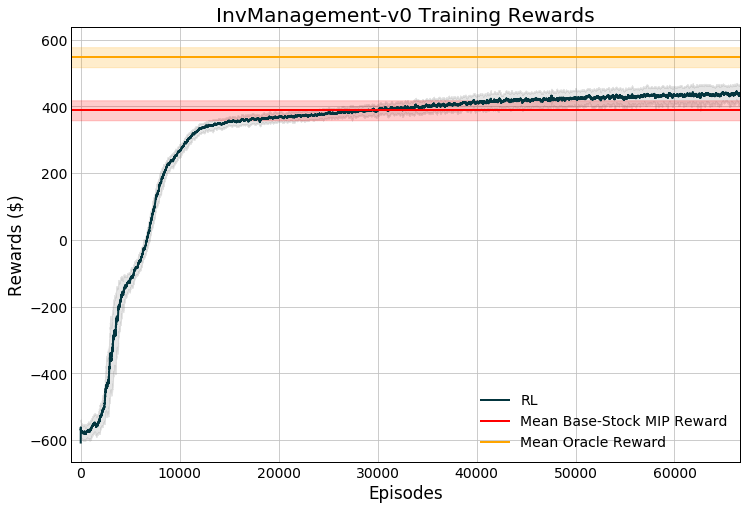

In [36]:
# Get episode totals
x_min = -1000
x_max = inv0_data.shape[0]
opt_mean = 547
opt_var = 30
heur_mean = 388
heur_var = 30


plt.figure(figsize=(12,8))
plt.plot(data['mean_rewards'], label='RL')
plt.fill_between(np.arange(x_max), data['fill_min'], data['fill_max'],
                 color='gray', alpha=0.2)

# plt.plot(a3c_data['mean_rewards'], label='RL (A3C)', color=colors[1])
# plt.fill_between(np.arange(a3c_data.shape[0]), a3c_data['fill_min'], a3c_data['fill_max'],
#                  color='blue', alpha=0.2)

plt.axhline(xmin=0, xmax=x_max, y=heur_mean, color='r', label='Mean Base-Stock MIP Reward')
plt.fill_between(np.arange(x_min, x_max), heur_mean-heur_var, 
                 heur_mean+heur_var, color='r', alpha=0.2)

plt.axhline(xmin=0, xmax=x_max, y=opt_mean, color='orange', label='Mean Oracle Reward')
plt.fill_between(np.arange(x_min, x_max), opt_mean-opt_var, 
                 opt_mean+opt_var, color='orange', alpha=0.2)

plt.title('InvManagement-v0 Training Rewards')
# plt.legend(bbox_to_anchor=[1.45, 0.75])
plt.legend()
plt.xlabel('Episodes')
plt.xlim([x_min, x_max])
plt.ylabel('Rewards ($)')
plt.show()

In [37]:
inv0_train_data.tail()

,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episodes_this_iter,optimizer_steps_this_iter,timesteps_this_iter,done,timesteps_total,episodes_total,...,perf/ram_util_percent,info/learner/default_policy/cur_kl_coeff,info/learner/default_policy/cur_lr,info/learner/default_policy/total_loss,info/learner/default_policy/policy_loss,info/learner/default_policy/vf_loss,info/learner/default_policy/vf_explained_var,info/learner/default_policy/kl,info/learner/default_policy/entropy,info/learner/default_policy/entropy_coeff
495,488.242957,353.470543,435.378950,30.0,132,1,4000,False,1984000,66132,...,46.4,0.759375,0.00001,89.207050,-0.033133,89.270615,0.995666,0.012557,3.998165,0.01
496,485.344215,358.229167,442.597702,30.0,134,1,4000,False,1988000,66266,...,46.4,0.759375,0.00001,116.464390,-0.044434,116.535230,0.994288,0.014328,3.727607,0.01
497,482.758688,369.586405,438.296862,30.0,134,1,4000,False,1992000,66400,...,46.4,0.759375,0.00001,105.628975,-0.039774,105.697520,0.994906,0.013317,3.887248,0.01
498,489.122934,327.366349,434.176667,30.0,132,1,4000,False,1996000,66532,...,46.4,0.759375,0.00001,107.178310,-0.036549,107.243950,0.994845,0.014492,4.010488,0.01
499,484.456665,349.136223,438.806596,30.0,134,1,4000,True,2000000,66666,...,46.4,0.759375,0.00001,107.353920,-0.037759,107.419630,0.994774,0.013874,3.849361,0.01


In [23]:
import ray
from ray.rllib import agents
import json
from or_gym.algos.rl_utils import create_env
ray.init(ignore_reinit_error=True)

2020-05-21 09:37:05,003	WARNING services.py:597 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-05-21 09:37:05,004	INFO resource_spec.py:216 -- Starting Ray with 1.61 GiB memory available for workers and up to 0.82 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


{'node_ip_address': '192.168.0.11',
 'redis_address': '192.168.0.11:29555',
 'object_store_address': '/tmp/ray/session_2020-05-21_09-37-05_002761_17527/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-05-21_09-37-05_002761_17527/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2020-05-21_09-37-05_002761_17527'}

In [120]:
path = "/home/christian/ray_results/PPO/PPO_InvManagement-v0_3_entropy_coeff=0.01,lr=1e-05_2020-05-19_20-59-32_o_4ganr"

def load_policy(path, checkpoint_id="500"):
    with open(f"{path}/params.json", "r") as read_file:
        config = json.load(read_file)
    split_path = path.split('/')
    algo = [j for i, j in enumerate(split_path) if split_path[i-1] == 'ray_results'][0].lower()
    if hasattr(agents, algo):
        agent = getattr(agents, algo)
    
    trainer = getattr(agent, algo.upper() + 'Trainer')(config, env=create_env(config['env']))
    trainer.restore(f"{path}/checkpoint_{checkpoint_id}/checkpoint-{checkpoint_id}")
    return trainer

trainer = load_policy(path)
env = trainer.env_creator(trainer.config)

2020-05-21 13:18:19,378	WARNING util.py:45 -- Install gputil for GPU system monitoring.
2020-05-21 13:18:19,476	INFO trainable.py:346 -- Restored from checkpoint: /home/christian/ray_results/PPO/PPO_InvManagement-v0_3_entropy_coeff=0.01,lr=1e-05_2020-05-19_20-59-32_o_4ganr/checkpoint_500/checkpoint-500
2020-05-21 13:18:19,477	INFO trainable.py:353 -- Current state after restoring: {'_iteration': 500, '_timesteps_total': 2000000, '_time_total': 2842.1430311203003, '_episodes_total': 66666}


# Load Optimization Results

In [4]:
import pickle

In [121]:
opt_path = 'NewsVendor/NV Runs'
opt_files = os.listdir(opt_path)
opt_results = {}
opt_inv = {}
opt_trans = {}
bl_30 = []
for f in opt_files:
    if 'Backlog_30' in f:
        _opt_path = opt_path + '/' + f
        bl_30.append(_opt_path)
        opt_data = pickle.load(open(_opt_path, 'rb'))
        for k in opt_data.keys():
            if 'or_gym.envs' in str(type(opt_data[k])):
                try:
                    opt_results[k].append(opt_data[k].P)
                    opt_inv[k].append(opt_data[k].I)
                    opt_trans[k].append(opt_data[k].T)
                except KeyError:
                    opt_results[k] = [opt_data[k].P]
                    opt_inv[k] = [opt_data[k].I]
                    opt_trans[k] = [opt_data[k].T]

In [122]:
n_episodes = 10
rewards = np.zeros((n_episodes, env.num_periods))
states = []
for i in range(n_episodes):
    state = env.reset()
    done = False
    _states, actions = [], []
    j = 0
    while done == False:
        _states.append(state)
        action = trainer.compute_action(state)
        state, reward, done, info = env.step(action)
        actions.append(action)
        rewards[i, j] += reward
        j += 1
        if done:
            states.append(_states)
            break

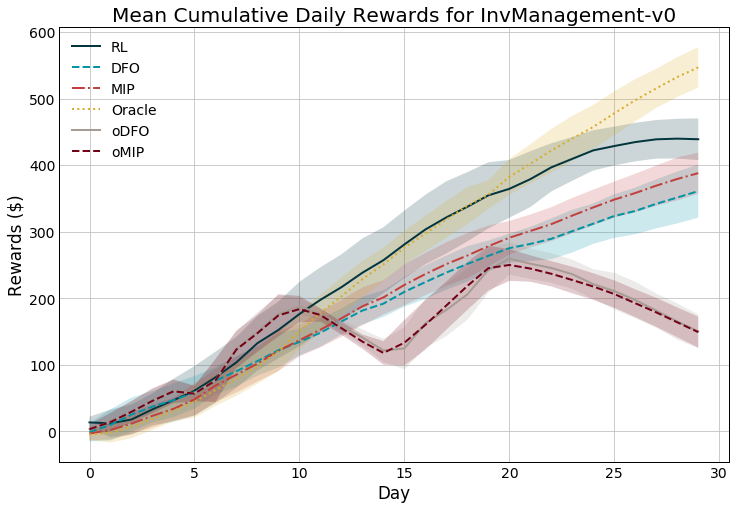

In [123]:
ppo_rewards = np.cumsum(rewards.mean(axis=0))
ppo_var = np.cumsum(rewards, axis=1).std(axis=0)

plt.figure(figsize=(12,8))
plt.plot(ppo_rewards, label='RL')
plt.fill_between(np.arange(env.num_periods), ppo_rewards - ppo_var, ppo_rewards + ppo_var,
                alpha=0.2)

linestyles = ['--', '-.', ':', '-']
for i, k in enumerate(opt_results.keys()):
    opt_rewards = np.cumsum(np.vstack(opt_results[k]), axis=1)
    opt_var = opt_rewards.std(axis=0).flatten()
    linestyle = linestyles[i % len(linestyles)]
    plt.plot(opt_rewards.mean(axis=0), label=k, linestyle=linestyle)
    plt.fill_between(np.arange(env.num_periods), opt_rewards.mean(axis=0) - opt_var, 
        opt_rewards.mean(axis=0) + opt_var, alpha=0.2)

plt.xlabel('Day')
plt.ylabel('Rewards ($)')
plt.title('Mean Cumulative Daily Rewards for InvManagement-v0')
plt.legend()
plt.show()

In [124]:
rl_rewards = inv0_train_data.iloc[-1]['episode_reward_mean']
oracle_rewards = np.sum(np.vstack(opt_results['Oracle']), axis=1).mean()
print("{}\tMean Rewards = {:.1f}\tPerf Ratio = {:.1f}\tStd Rewards = {:.1f}".format(
    'RL', rl_rewards, oracle_rewards/rl_rewards, inv0_data.iloc[-1]['std_rewards']))
for i, k in enumerate(opt_results.keys()):
    r = np.vstack(opt_results[k]).sum(axis=1)
    opt_rewards = r.mean()
    opt_var = r.std()
    print("{}\tMean Rewards = {:.1f}\tPerf Ratio = {:.1f}\tStd Rewards = {:.1f}".format(
        k, opt_rewards, oracle_rewards/opt_rewards, opt_var))

RL	Mean Rewards = 438.8	Perf Ratio = 1.2	Std Rewards = 30.6
DFO	Mean Rewards = 360.9	Perf Ratio = 1.5	Std Rewards = 39.9
MIP	Mean Rewards = 388.0	Perf Ratio = 1.4	Std Rewards = 30.8
Oracle	Mean Rewards = 546.8	Perf Ratio = 1.0	Std Rewards = 30.3
oDFO	Mean Rewards = 150.3	Perf Ratio = 3.6	Std Rewards = 25.4
oMIP	Mean Rewards = 149.1	Perf Ratio = 3.7	Std Rewards = 23.3


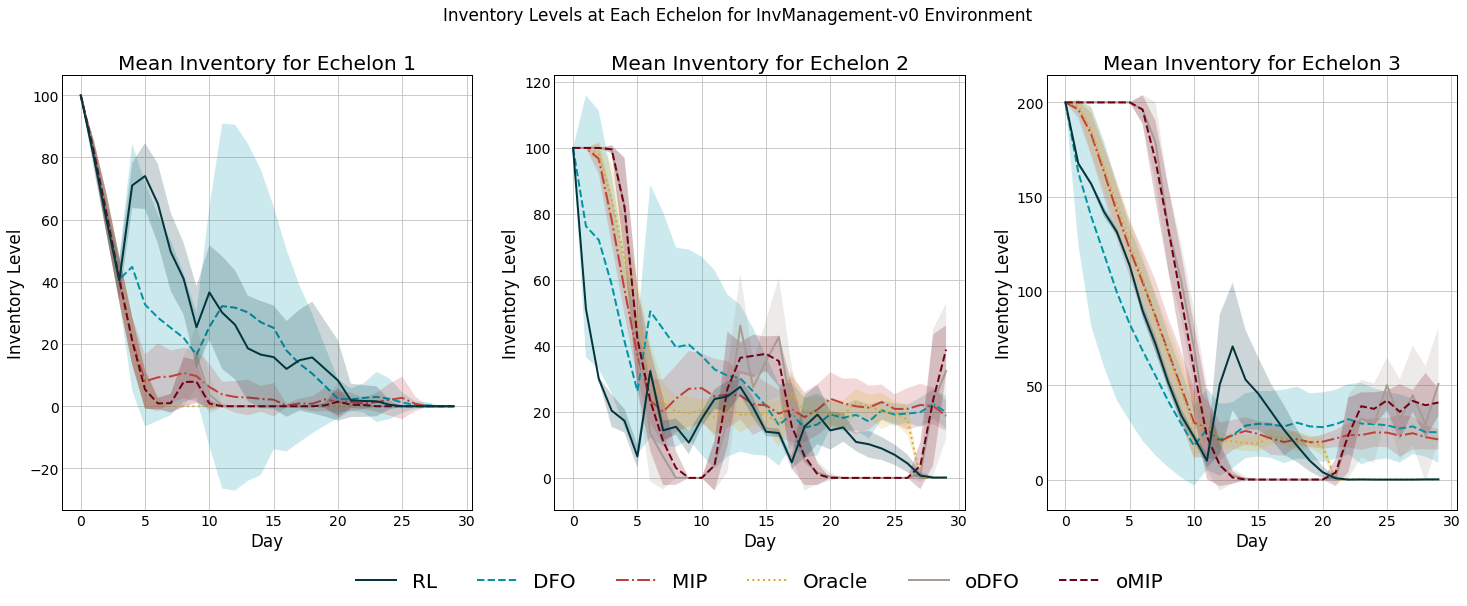

In [125]:
rl_states = np.vstack(states)[:, :3].reshape(-1, env.num_periods, env.num_stages-1)
rl_inv_mean = rl_states.mean(axis=0)
rl_inv_std = rl_states.std(axis=0)

fig, ax = plt.subplots(1, 3, figsize=(25, 8))

for i in range(env.num_stages-1):
    ax[i].plot(rl_inv_mean[:,i], label='RL', zorder=10)
    ax[i].fill_between(np.arange(env.num_periods), 
        rl_inv_mean[:,i] - rl_inv_std[:,i], rl_inv_mean[:,i] + rl_inv_std[:,i],
                alpha=0.2, zorder=10)
    
    for j, k in enumerate(opt_inv.keys()):
        # Each entry has one extra entry
        inv = np.vstack(opt_inv[k]).reshape(-1, env.num_periods+1, env.num_stages-1)
        inv_mean = inv.mean(axis=0)[:-1,i]
        inv_std = inv.std(axis=0)[:-1,i]
        
        linestyle = linestyles[j % len(linestyles)]
        ax[i].plot(inv_mean, label=k, linestyle=linestyle)
        ax[i].fill_between(np.arange(env.num_periods), inv_mean - inv_std, inv_mean + inv_std, alpha=0.2)
    
    ax[i].set_title('Mean Inventory for Echelon {}'.format(i+1))
    ax[i].set_ylabel('Inventory Level')
    ax[i].set_xlabel('Day')
    
ax[1].legend(loc='upper center', ncol=6, bbox_to_anchor=(0.5, -0.1), prop={'size': 20})
# plt.tight_layout()
plt.suptitle('Inventory Levels at Each Echelon for InvManagement-v0 Environment', y=1.0)
plt.show()

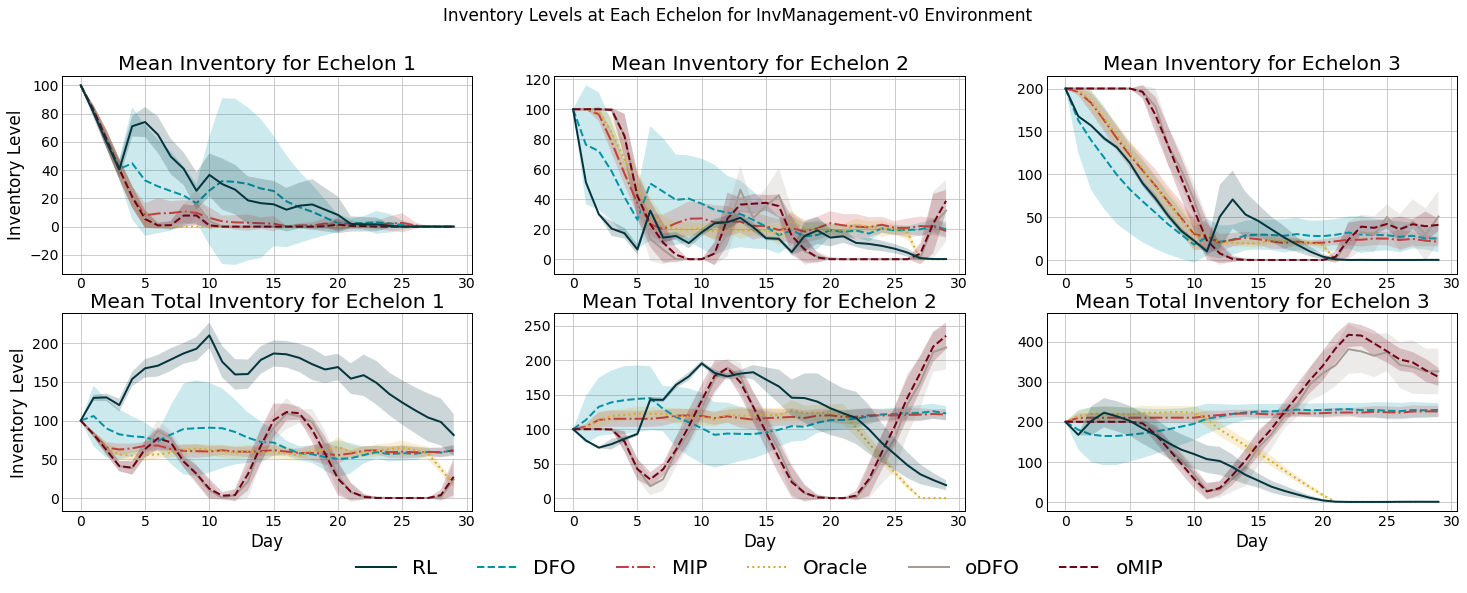

In [126]:
# Shot echeclon and total inventory
rl_states = np.vstack(states).reshape(-1, env.num_periods, env.observation_space.shape[0])
rl_inv_mean = rl_states.mean(axis=0)
rl_inv_std = rl_states.std(axis=0)

fig, ax = plt.subplots(2, 3, figsize=(25, 8))

for i in range(env.num_stages-1):
    ax[0, i].plot(rl_inv_mean[:,i], label='RL', zorder=10)
    ax[0, i].fill_between(np.arange(env.num_periods), 
        rl_inv_mean[:,i] - rl_inv_std[:,i], rl_inv_mean[:,i] + rl_inv_std[:,i],
                alpha=0.2, zorder=10)
    idx = np.arange(i, env.observation_space.shape[0], env.num_stages-1)
    tot_inv_mean = rl_states[:,:,idx].sum(axis=2).mean(axis=0)
    tot_inv_std = rl_states[:,:,idx].sum(axis=2).std(axis=0)
    ax[1, i].plot(tot_inv_mean, label='RL', zorder=10)
    ax[1, i].fill_between(np.arange(env.num_periods),
        tot_inv_mean - tot_inv_std, tot_inv_mean + tot_inv_std,
        alpha=0.2, zorder=9)
    
    for j, k in enumerate(opt_inv.keys()):
        # Each entry has one extra entry
        inv = np.vstack(opt_inv[k]).reshape(-1, env.num_periods+1, env.num_stages-1)
        inv_trans = np.vstack(opt_trans[k]).reshape(-1, env.num_periods+1, env.num_stages-1)
        inv_mean = inv.mean(axis=0)[:-1,i]
        inv_std = inv.std(axis=0)[:-1,i]
        
        inv_trans_mean = inv_trans.mean(axis=0)[:-1,i]
        inv_trans_std = inv_trans.std(axis=0)[:-1,i]
        
        tot_inv = inv + inv_trans
        tot_inv_mean = tot_inv.mean(axis=0)[:-1,i]
        tot_inv_std = tot_inv.std(axis=0)[:-1,i]
        
        linestyle = linestyles[j % len(linestyles)]
        ax[0, i].plot(inv_mean, label=k, linestyle=linestyle)
        ax[0, i].fill_between(np.arange(env.num_periods), inv_mean - inv_std, inv_mean + inv_std, alpha=0.2)
        
        ax[1, i].plot(tot_inv_mean, label=k, linestyle=linestyle)
        ax[1, i].fill_between(np.arange(env.num_periods), 
            tot_inv_mean - tot_inv_std, tot_inv_mean + tot_inv_std, alpha=0.2)
    
    ax[0, i].set_title('Mean Inventory for Echelon {}'.format(i+1))
    ax[1, i].set_title('Mean Total Inventory for Echelon {}'.format(i+1))
    ax[0, 0].set_ylabel('Inventory Level')
    ax[1, 0].set_ylabel('Inventory Level')
    ax[1, i].set_xlabel('Day')
    
ax[1, 1].legend(loc='upper center', ncol=6, bbox_to_anchor=(0.5, -0.15), prop={'size': 20})
# plt.tight_layout()
plt.suptitle('Inventory Levels at Each Echelon for InvManagement-v0 Environment', y=1.0)
plt.show()

# InvManagement-v1

In [21]:
inv1_path = '/home/christian/ray_results/PPO/PPO_InvManagement-v1_0_lr=0.0001_2020-05-20_19-27-518qt5htde'
inv1_data, inv1_train_data = extract_plot_stats(inv1_path)

In [110]:
opt_path = 'NewsVendor/NV Runs'
opt_files = os.listdir(opt_path)
opt_results = {}
opt_inv = {}
bl_30 = []
for f in opt_files:
    if 'LostSales_30' in f:
        _opt_path = opt_path + '/' + f
        bl_30.append(_opt_path)
        opt_data = pickle.load(open(_opt_path, 'rb'))
        for k in opt_data.keys():
            if 'or_gym.envs' in str(type(opt_data[k])):
                try:
                    opt_results[k].append(opt_data[k].P)
                    opt_inv[k].append(opt_data[k].I)
                    opt_trans[k].append(opt_data[k].T)
                except KeyError:
                    opt_results[k] = [opt_data[k].P]
                    opt_inv[k] = [opt_data[k].I]
                    opt_trans[k] = [opt_data[k].T]
                    
or_rews = np.vstack(opt_results['Oracle']).sum(axis=1)
mip_rews = np.vstack(opt_results['MIP']).sum(axis=1)

print("Oracle Mean = {:.1f}\tOracle STD = {:.1f}".format(or_rews.mean(), or_rews.std()))
print("MIP Mean = {:.1f}\tMIP STD = {:.1f}".format(mip_rews.mean(), mip_rews.std()))

Oracle Mean = 542.7	Oracle STD = 29.9
MIP Mean = 378.5	MIP STD = 26.1


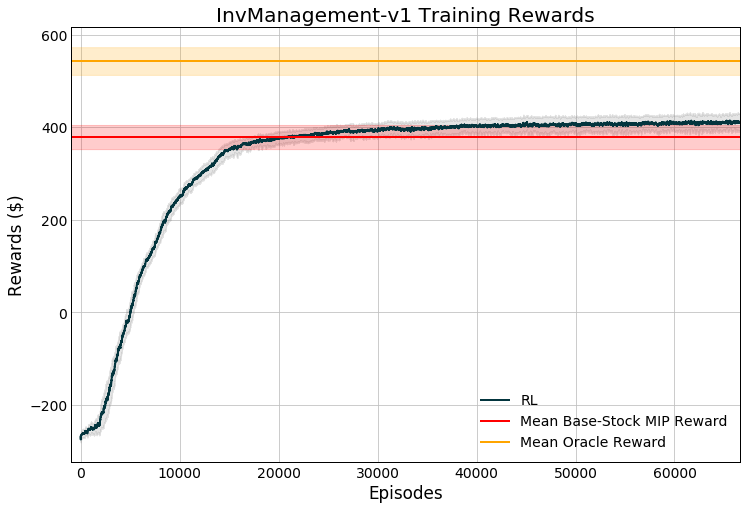

In [16]:
# Get episode totals
x_min = -1000
x_max = inv1_data.shape[0]
opt_mean = 542.7
opt_var = 29.9
heur_mean = 378.5
heur_var = 26.1


plt.figure(figsize=(12,8))
plt.plot(inv1_data['mean_rewards'], label='RL')
plt.fill_between(np.arange(inv1_data.shape[0]), inv1_data['fill_min'], inv1_data['fill_max'],
                 color='gray', alpha=0.2)

# plt.plot(a3c_data['mean_rewards'], label='RL (A3C)', color=colors[1])
# plt.fill_between(np.arange(a3c_data.shape[0]), a3c_data['fill_min'], a3c_data['fill_max'],
#                  color='blue', alpha=0.2)

plt.axhline(xmin=0, xmax=x_max, y=heur_mean, color='r', label='Mean Base-Stock MIP Reward')
plt.fill_between(np.arange(x_min, inv1_data.shape[0]), heur_mean-heur_var, 
                 heur_mean+heur_var, color='r', alpha=0.2)

plt.axhline(xmin=0, xmax=x_max, y=opt_mean, color='orange', label='Mean Oracle Reward')
plt.fill_between(np.arange(x_min, inv1_data.shape[0]), opt_mean-opt_var, 
                 opt_mean+opt_var, color='orange', alpha=0.2)

plt.title('InvManagement-v1 Training Rewards')
# plt.legend(bbox_to_anchor=[1.45, 0.75])
plt.legend()
plt.xlabel('Episodes')
plt.xlim([x_min, x_max])
plt.ylabel('Rewards ($)')
plt.show()

In [111]:
rl_rewards = inv1_train_data.iloc[-1]['episode_reward_mean']
oracle_rewards = np.sum(np.vstack(opt_results['Oracle']), axis=1).mean()
print("{}\tMean Rewards = {:.1f}\tPerf Ratio = {:.1f}\tStd Rewards = {:.1f}".format(
    'RL', rl_rewards, oracle_rewards/rl_rewards, inv1_data.iloc[-1]['std_rewards']))
for i, k in enumerate(opt_results.keys()):
    r = np.vstack(opt_results[k]).sum(axis=1)
    opt_rewards = r.mean()
    opt_var = r.std()
    print("{}\tMean Rewards = {:.1f}\tPerf Ratio = {:.1f}\tStd Rewards = {:.1f}".format(
        k, opt_rewards, oracle_rewards/opt_rewards, opt_var))

RL	Mean Rewards = 409.8	Perf Ratio = 1.3	Std Rewards = 17.9
DFO	Mean Rewards = 364.3	Perf Ratio = 1.5	Std Rewards = 33.8
MIP	Mean Rewards = 378.5	Perf Ratio = 1.4	Std Rewards = 26.1
Oracle	Mean Rewards = 542.7	Perf Ratio = 1.0	Std Rewards = 29.9
oDFO	Mean Rewards = 235.2	Perf Ratio = 2.3	Std Rewards = 51.8
oMIP	Mean Rewards = 223.5	Perf Ratio = 2.4	Std Rewards = 16.4


In [117]:
def load_policy(path, checkpoint_id="500"):
    with open(f"{path}/params.json", "r") as read_file:
        config = json.load(read_file)
    split_path = path.split('/')
    algo = [j for i, j in enumerate(split_path) if split_path[i-1] == 'ray_results'][0].lower()
    if hasattr(agents, algo):
        agent = getattr(agents, algo)
    
    trainer = getattr(agent, algo.upper() + 'Trainer')(config, env=create_env(config['env']))
    trainer.restore(f"{path}/checkpoint_{checkpoint_id}/checkpoint-{checkpoint_id}")
    return trainer

trainer = load_policy(inv1_path)
env = trainer.env_creator(trainer.config)

n_episodes = 10
rewards = np.zeros((n_episodes, env.num_periods))
states = []
for i in range(n_episodes):
    state = env.reset()
    done = False
    _states, actions = [], []
    j = 0
    while done == False:
        _states.append(state)
        action = trainer.compute_action(state)
        state, reward, done, info = env.step(action)
        actions.append(action)
        rewards[i, j] += reward
        j += 1
        if done:
            states.append(_states)
            break

2020-05-21 13:17:06,481	WARNING util.py:45 -- Install gputil for GPU system monitoring.
2020-05-21 13:17:06,552	INFO trainable.py:346 -- Restored from checkpoint: /home/christian/ray_results/PPO/PPO_InvManagement-v1_0_lr=0.0001_2020-05-20_19-27-518qt5htde/checkpoint_500/checkpoint-500
2020-05-21 13:17:06,553	INFO trainable.py:353 -- Current state after restoring: {'_iteration': 500, '_timesteps_total': 2000000, '_time_total': 5717.712861061096, '_episodes_total': 66666}


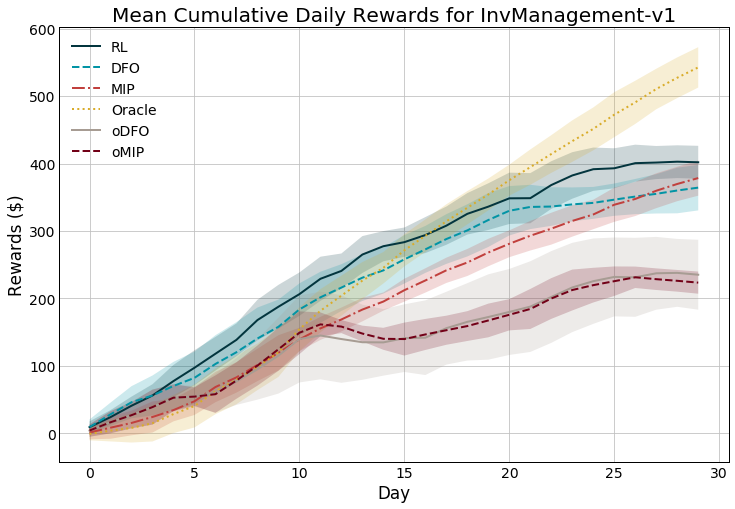

In [113]:
ppo_rewards = np.cumsum(rewards.mean(axis=0))
ppo_var = np.cumsum(rewards, axis=1).std(axis=0)

plt.figure(figsize=(12,8))
plt.plot(ppo_rewards, label='RL')
plt.fill_between(np.arange(env.num_periods), ppo_rewards - ppo_var, ppo_rewards + ppo_var,
                alpha=0.2)

linestyles = ['--', '-.', ':', '-']
for i, k in enumerate(opt_results.keys()):
    opt_rewards = np.cumsum(np.vstack(opt_results[k]), axis=1)
    opt_var = opt_rewards.std(axis=0).flatten()
    linestyle = linestyles[i % len(linestyles)]
    plt.plot(opt_rewards.mean(axis=0), label=k, linestyle=linestyle)
    plt.fill_between(np.arange(env.num_periods), opt_rewards.mean(axis=0) - opt_var, 
        opt_rewards.mean(axis=0) + opt_var, alpha=0.2)

plt.xlabel('Day')
plt.ylabel('Rewards ($)')
plt.title('Mean Cumulative Daily Rewards for InvManagement-v1')
plt.legend()
plt.show()

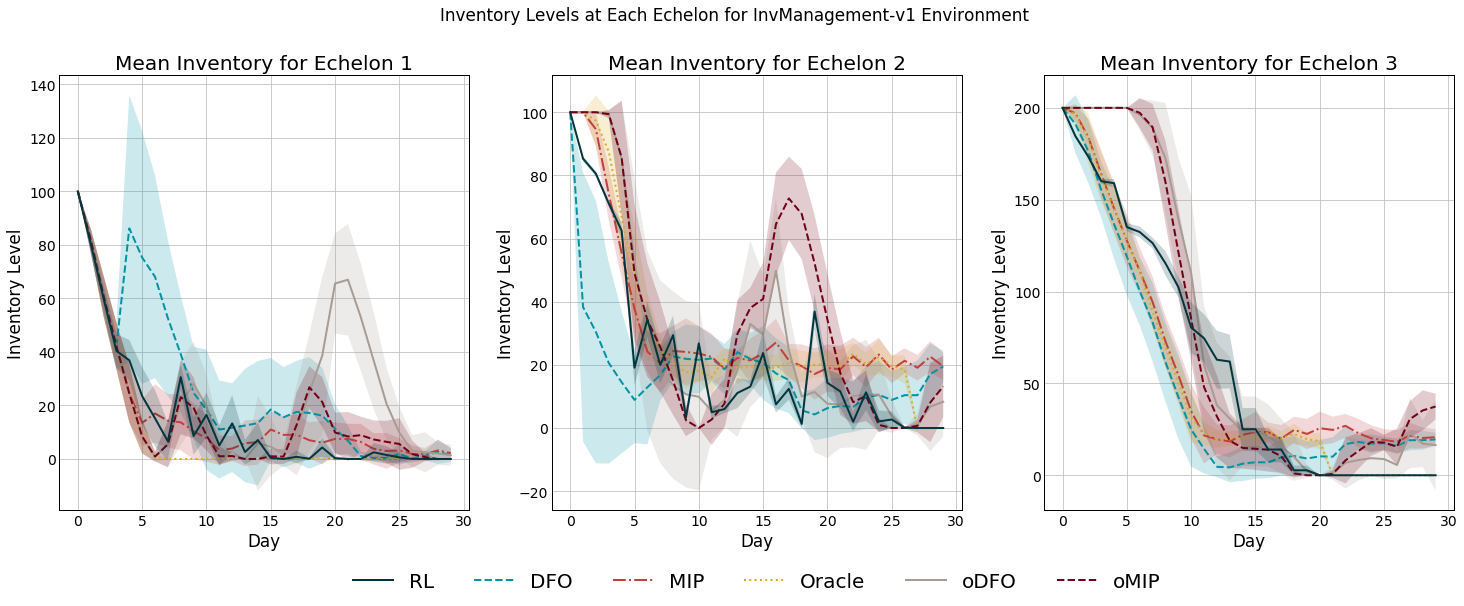

In [114]:
rl_states = np.vstack(states)[:, :3].reshape(-1, env.num_periods, env.num_stages-1)
rl_inv_mean = rl_states.mean(axis=0)
rl_inv_std = rl_states.std(axis=0)

fig, ax = plt.subplots(1, 3, figsize=(25, 8))

for i in range(env.num_stages-1):
    ax[i].plot(rl_inv_mean[:,i], label='RL', zorder=10)
    ax[i].fill_between(np.arange(env.num_periods), 
        rl_inv_mean[:,i] - rl_inv_std[:,i], rl_inv_mean[:,i] + rl_inv_std[:,i],
                alpha=0.2, zorder=10)
    
    for j, k in enumerate(opt_inv.keys()):
        # Each entry has one extra entry
        inv = np.vstack(opt_inv[k]).reshape(-1, env.num_periods+1, env.num_stages-1)
        inv_mean = inv.mean(axis=0)[:-1,i]
        inv_std = inv.std(axis=0)[:-1,i]
        
        linestyle = linestyles[j % len(linestyles)]
        ax[i].plot(inv_mean, label=k, linestyle=linestyle)
        ax[i].fill_between(np.arange(env.num_periods), inv_mean - inv_std, inv_mean + inv_std, alpha=0.2)
    
    ax[i].set_title('Mean Inventory for Echelon {}'.format(i+1))
    ax[i].set_ylabel('Inventory Level')
    ax[i].set_xlabel('Day')
    
ax[1].legend(loc='upper center', ncol=6, bbox_to_anchor=(0.5, -0.1), prop={'size': 20})
# plt.tight_layout()
plt.suptitle('Inventory Levels at Each Echelon for InvManagement-v1 Environment', y=1.0)
plt.show()

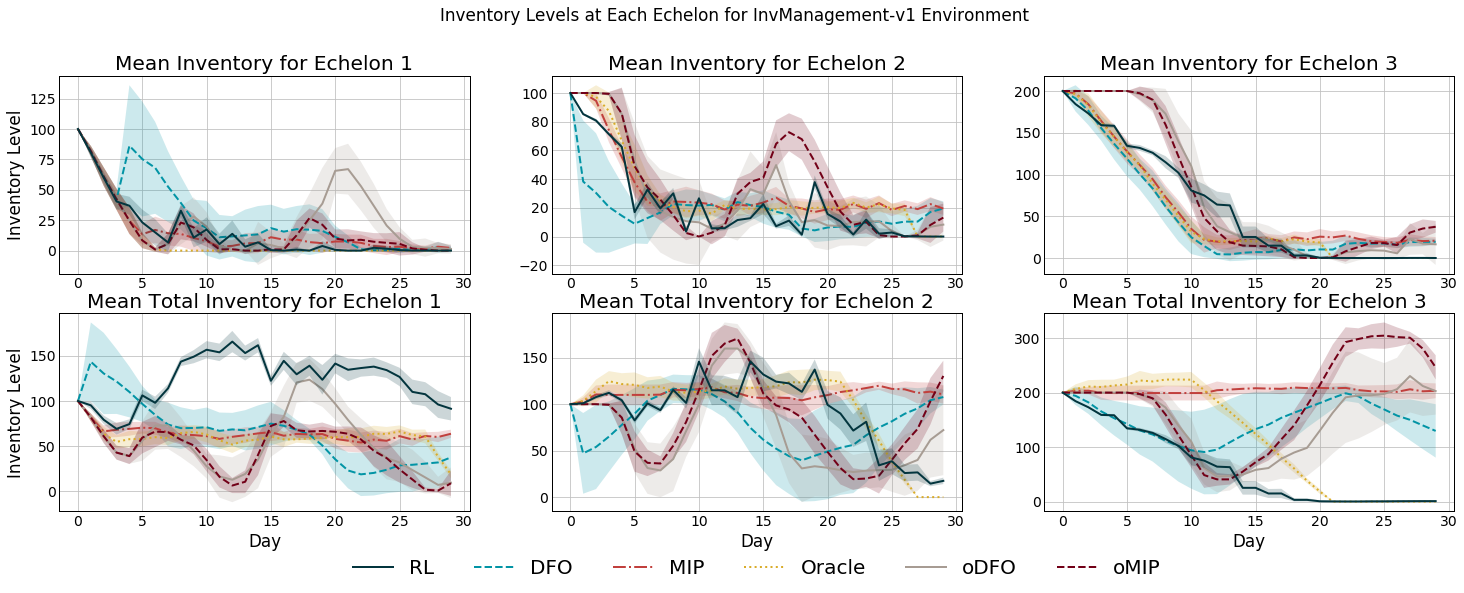

In [118]:
# Show echelon and total inventory levels
rl_states = np.vstack(states).reshape(-1, env.num_periods, env.observation_space.shape[0])
rl_inv_mean = rl_states.mean(axis=0)
rl_inv_std = rl_states.std(axis=0)

fig, ax = plt.subplots(2, 3, figsize=(25, 8))

for i in range(env.num_stages-1):
    ax[0, i].plot(rl_inv_mean[:,i], label='RL', zorder=10)
    ax[0, i].fill_between(np.arange(env.num_periods), 
        rl_inv_mean[:,i] - rl_inv_std[:,i], rl_inv_mean[:,i] + rl_inv_std[:,i],
                alpha=0.2, zorder=10)
    idx = np.arange(i, env.observation_space.shape[0], env.num_stages-1)
    tot_inv_mean = rl_states[:,:,idx].sum(axis=2).mean(axis=0)
    tot_inv_std = rl_states[:,:,idx].sum(axis=2).std(axis=0)
    ax[1, i].plot(tot_inv_mean, label='RL', zorder=10)
    ax[1, i].fill_between(np.arange(env.num_periods),
        tot_inv_mean - tot_inv_std, tot_inv_mean + tot_inv_std,
        alpha=0.2, zorder=9)
    
    for j, k in enumerate(opt_inv.keys()):
        # Each entry has one extra entry
        inv = np.vstack(opt_inv[k]).reshape(-1, env.num_periods+1, env.num_stages-1)
        inv_trans = np.vstack(opt_trans[k]).reshape(-1, env.num_periods+1, env.num_stages-1)
        inv_mean = inv.mean(axis=0)[:-1,i]
        inv_std = inv.std(axis=0)[:-1,i]
        
        inv_trans_mean = inv_trans.mean(axis=0)[:-1,i]
        inv_trans_std = inv_trans.std(axis=0)[:-1,i]
        
        tot_inv = inv + inv_trans
        tot_inv_mean = tot_inv.mean(axis=0)[:-1,i]
        tot_inv_std = tot_inv.std(axis=0)[:-1,i]
        
        linestyle = linestyles[j % len(linestyles)]
        ax[0, i].plot(inv_mean, label=k, linestyle=linestyle)
        ax[0, i].fill_between(np.arange(env.num_periods), inv_mean - inv_std, inv_mean + inv_std, alpha=0.2)
        
        ax[1, i].plot(tot_inv_mean, label=k, linestyle=linestyle)
        ax[1, i].fill_between(np.arange(env.num_periods), 
            tot_inv_mean - tot_inv_std, tot_inv_mean + tot_inv_std, alpha=0.2)
    
    ax[0, i].set_title('Mean Inventory for Echelon {}'.format(i+1))
    ax[1, i].set_title('Mean Total Inventory for Echelon {}'.format(i+1))
    ax[0, 0].set_ylabel('Inventory Level')
    ax[1, 0].set_ylabel('Inventory Level')
    ax[1, i].set_xlabel('Day')
    
ax[1, 1].legend(loc='upper center', ncol=6, bbox_to_anchor=(0.5, -0.15), prop={'size': 20})
# plt.tight_layout()
plt.suptitle('Inventory Levels at Each Echelon for InvManagement-v1 Environment', y=1.0)
plt.show()